 ## Trabajo N.º 3 
## Integración de árboles de decisión y clustering jerárquico en la modelación de patrones sísmicos en Chile


### Abstract

Este trabajo integra y extiende los análisis realizados en las Evaluaciones 1 y 2 sobre la actividad sísmica en Chile, utilizando el mismo conjunto de datos de eventos registrados por el Centro Sismológico Nacional entre 2012 y 2025. El objetivo central es comparar el rendimiento e interpretabilidad de distintos modelos de regresión, incorporar árboles de decisión tanto regresivos como lógicos, y aplicar técnicas de clustering jerárquico para identificar patrones de agrupamiento en la magnitud, profundidad y localización de los sismos.

A partir de las variables numéricas principales (Latitude, Longitude, Depth, Magnitude) y de la etiqueta derivada zona_sismica, se construyen y evalúan modelos de regresión lineal y basados en árboles, así como un árbol de decisión de clasificación y clústeres jerárquicos en variantes aditiva y divisiva. Los resultados permiten contrastar los modelos de las evaluaciones anteriores, visualizar reglas de decisión explícitas y descubrir grupos de eventos con comportamientos similares. Finalmente, se formulan conclusiones y recomendaciones de negocio orientadas a mejorar la interpretación de los patrones sísmicos y apoyar la priorización de zonas de vigilancia.


## 1. Introducción

Chile es uno de los países con mayor actividad sísmica del mundo, lo que convierte a la medición, análisis y comunicación de los sismos en un problema permanente de seguridad y de gestión del riesgo. En las Evaluaciones 1 y 2 se trabajó con un conjunto de datos del Centro Sismológico Nacional, explorando la distribución de magnitudes y profundidades, comparando macrozonas y desarrollando modelos de regresión y clasificación básicos.

En esta tercera entrega se retoma el mismo dataset, pero con un foco más integrado y reflexivo. Nuestro interés no es solo aplicar nuevas técnicas, sino también comparar lo realizado anteriormente y preguntarse qué modelos aportan mayor capacidad de explicación y apoyo a la toma de decisiones. Este trabajo busca profundizar la comprensión de cómo variables como latitud, longitud, profundidad y magnitud se relacionan entre sí, y cómo los modelos pueden ayudar a mejorar la detección de patrones relevantes para la gestión sísmica.

La integración de árboles de decisión y clustering jerárquico permite avanzar hacia modelos más interpretables, donde las reglas y los agrupamientos puedan explicarse de manera sencilla a usuarios no técnicos, manteniendo al mismo tiempo una base cuantitativa sólida.


## 3. Equipos, software y librerías utilizadas

### 3.1 Equipo de trabajo

El análisis se realizó en computadores con las siguientes características relevantes para el procesamiento de datos:

- Procesador Intel Core i7
- Memoria RAM 16 GB 
- Unidad de almacenamiento sólido (SSD) de 512 GB y 1 TB
- Tarjetas de video: Intel UHD Graphics Xe (integrada) y NVIDIA GeForce RTX 3060
- Sistema operativo Windows 10 de 64 bits.

Estas especificaciones permiten trabajar de forma fluida con notebooks de Python, manejar dataframes de tamaño medio y ejecutar modelos de Machine Learning de complejidad moderada sin problemas de rendimiento.

### 3.2 Software, entorno de desarrollo y trabajo colaborativo

- Lenguaje: Python 3.12.10.
- Entorno de desarrollo: Visual Studio Code con la extensión de Jupyter Notebook.
- Sistema de control de versiones: Git y GitHub.
- Cliente de escritorio: GitHub Desktop para sincronizar el repositorio entre distintos computadores de trabajo.
- Estructura de carpetas:
  - data/: contiene el archivo seismic_data.csv con los registros sísmicos.
  - figuras/: almacena las imágenes generadas por los gráficos del análisis.

El proyecto se gestionó mediante un repositorio en GitHub, utilizando GitHub Desktop para realizar commit, push y pull de los cambios entre equipos. Visual Studio Code se utilizó como editor principal para desarrollar el notebook, gestionar ramas cuando fue necesario y revisar el historial de versiones, lo que facilitó el trabajo colaborativo.

### 3.3 Librerías principales

Las librerías de Python más utilizadas en este trabajo son:

- pandas y numpy para manipulación y preparación de datos.
- matplotlib y seaborn para visualización de gráficos descriptivos y comparativos.
- scikit-learn para construcción y evaluación de modelos de regresión, árboles de decisión, clasificación y clustering jerárquico.
- nbformat e ipykernel como soporte para la ejecución reproducible del notebook.

Las versiones específicas de estas dependencias se encuentran documentadas en el archivo requirements.txt del proyecto.



In [3]:
# =============================================================================
# 4. CONFIGURACIÓN GENERAL DEL PROYECTO
# =============================================================================

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo de gráficos y opciones de Pandas
plt.style.use("default")
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Directorios base
DATA_DIR = "data"
FIG_DIR = "figuras"

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

def guardar_figura(fig, nombre):
    """
    Guarda una figura en la carpeta 'figuras' con nombre <nombre>.png
    """
    ruta = os.path.join(FIG_DIR, f"{nombre}.png")
    fig.savefig(ruta, dpi=300, bbox_inches="tight")
    print(f"Figura guardada en: {ruta}")


In [4]:
# =============================================================================
# 5. CARGA DEL DATASET SÍSMICO
# =============================================================================

NOMBRE_ARCHIVO = "seismic_data.csv"
ruta_csv = os.path.join(DATA_DIR, NOMBRE_ARCHIVO)

if not os.path.exists(ruta_csv):
    raise FileNotFoundError(
        f"No se encontró el archivo '{ruta_csv}'. "
        "Verifique que el CSV esté dentro de la carpeta 'data/'."
    )

print(f"Cargando dataset desde: {ruta_csv}")
df = pd.read_csv(ruta_csv)

print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")
display(df.head())


Cargando dataset desde: data\seismic_data.csv
Filas: 4018, Columnas: 5


,Date(UTC),Latitude,Longitude,Depth,Magnitude
0,2025-05-26 03:50:27,-19.6300,-69.4900,97,5.6000
1,2025-05-13 00:47:58,-51.2500,-72.2800,28,5.1000
2,2025-05-05 09:46:48,-29.4900,-71.8400,48,5.0000
3,2025-05-05 02:17:48,-31.8900,-70.8800,88,5.1000
4,2025-05-02 15:23:49,-27.5200,-72.4800,30,5.8000


In [5]:
# =============================================================================
# 6. PREPARACIÓN INICIAL DE VARIABLES
# =============================================================================

# Conversión de fecha a tipo datetime
df["Date"] = pd.to_datetime(df["Date(UTC)"], errors="coerce")

df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.to_period("M").astype(str)
df["Day"] = df["Date"].dt.day

def zona_por_lat(lat):
    """
    Asigna una macrozona sísmica aproximada según la latitud:
    - Norte: lat >= -23
    - Centro: -38 <= lat < -23
    - Sur: lat < -38
    """
    if pd.isna(lat):
        return np.nan
    if lat >= -23:
        return "Norte"
    elif lat <= -38:
        return "Sur"
    else:
        return "Centro"

df["zona_sismica"] = df["Latitude"].apply(zona_por_lat)

print("Distribución de la variable 'zona_sismica':")
print(df["zona_sismica"].value_counts(dropna=False))
display(df[["Date", "Latitude", "Longitude", "Depth", "Magnitude", "zona_sismica"]].head())


Distribución de la variable 'zona_sismica':
zona_sismica
Centro    2637
Norte     1266
Sur        115
Name: count, dtype: int64


,Date,Latitude,Longitude,Depth,Magnitude,zona_sismica
0,2025-05-26 03:50:27,-19.6300,-69.4900,97,5.6000,Norte
1,2025-05-13 00:47:58,-51.2500,-72.2800,28,5.1000,Sur
2,2025-05-05 09:46:48,-29.4900,-71.8400,48,5.0000,Centro
3,2025-05-05 02:17:48,-31.8900,-70.8800,88,5.1000,Centro
4,2025-05-02 15:23:49,-27.5200,-72.4800,30,5.8000,Centro


## 4. Comparativa de modelos de regresión

En esta sección se comparan dos enfoques de regresión aplicados a la magnitud de los sismos, utilizando como variables explicativas la latitud, longitud y profundidad:

- Un modelo de regresión lineal con variables estandarizadas, que representa el enfoque más clásico utilizado en las evaluaciones anteriores.
- Un árbol de decisión regresivo, que introduce el uso de modelos basados en reglas y particiones del espacio de atributos.

El objetivo es evaluar el rendimiento predictivo de cada modelo y discutir sus diferencias en términos de error, capacidad de ajuste e interpretabilidad.


In [7]:
# =============================================================================
# 4.1 Definición de modelos de regresión y evaluación comparativa
# =============================================================================

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ------------------------------
# Selección de variables
# ------------------------------
features_reg = ["Latitude", "Longitude", "Depth"]
target_reg = "Magnitude"

df_reg = df.dropna(subset=features_reg + [target_reg]).copy()
X = df_reg[features_reg]
y = df_reg[target_reg]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------
# Modelo 1: Regresión lineal (enfoque Evaluaciones 1 y 2)
# ------------------------------
modelo_lineal = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("regressor", LinearRegression())
    ]
)

# ------------------------------
# Modelo 2: Árbol de decisión regresivo )
# ------------------------------
modelo_arbol = DecisionTreeRegressor(
    random_state=42,
    max_depth=6,
    min_samples_leaf=20
)

# Entrenamiento
modelo_lineal.fit(X_train, y_train)
modelo_arbol.fit(X_train, y_train)

def evaluar_modelo_reg(nombre, modelo, X_train, X_test, y_train, y_test):
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)

    # MSE y RMSE 
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)

    r2_test = r2_score(y_test, y_pred_test)

    return {
        "Modelo": nombre,
        "MAE_train": mae_train,
        "MAE_test": mae_test,
        "RMSE_test": rmse_test,
        "R2_test": r2_test
    }

resultados_reg = []
resultados_reg.append(
    evaluar_modelo_reg(
        "Regresión lineal (enfoque Evaluaciones 1 y 2)",
        modelo_lineal,
        X_train, X_test, y_train, y_test
    )
)
resultados_reg.append(
    evaluar_modelo_reg(
        "Árbol de decisión regresivo ",
        modelo_arbol,
        X_train, X_test, y_train, y_test
    )
)

df_resultados_reg = pd.DataFrame(resultados_reg)
df_resultados_reg


,Modelo,MAE_train,MAE_test,RMSE_test,R2_test
0,Regresión lineal (enfoque Evaluaciones 1 y 2),0.5082,0.5343,0.6947,0.0357
1,Árbol de decisión regresivo,0.4611,0.5071,0.6592,0.1318


Figura guardada en: figuras\regresion_observados_vs_predichos.png


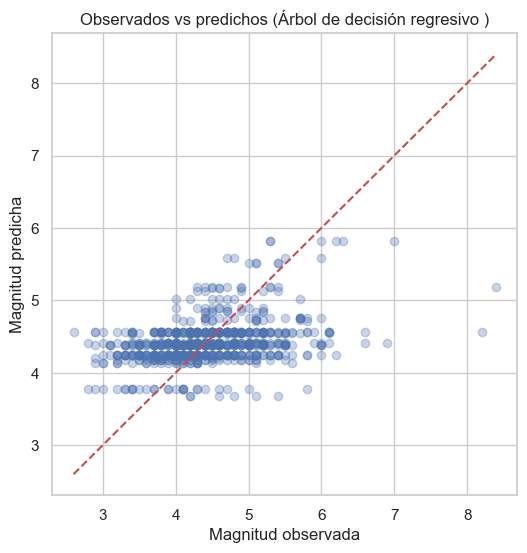

In [8]:
# =============================================================================
# 4.2 Gráfico observados vs predichos para el mejor modelo
# =============================================================================

# Seleccionar el modelo con menor RMSE en test
mejor_idx = df_resultados_reg["RMSE_test"].idxmin()
mejor_modelo_nombre = df_resultados_reg.loc[mejor_idx, "Modelo"]

if "Regresión lineal" in mejor_modelo_nombre:
    mejor_modelo = modelo_lineal
else:
    mejor_modelo = modelo_arbol

y_pred_test = mejor_modelo.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_test, y_pred_test, alpha=0.3)
lim_min = min(y_test.min(), y_pred_test.min())
lim_max = max(y_test.max(), y_pred_test.max())
ax.plot([lim_min, lim_max], [lim_min, lim_max], "r--")
ax.set_xlabel("Magnitud observada")
ax.set_ylabel("Magnitud predicha")
ax.set_title(f"Observados vs predichos ({mejor_modelo_nombre})")

guardar_figura(fig, "regresion_observados_vs_predichos")
plt.show()


### 4.3 Discusión de resultados de regresión

La tabla comparativa muestra que el árbol de decisión regresivo obtiene un error absoluto medio (MAE) y un RMSE ligeramente menores que la regresión lineal, junto con un valor de R² más alto. En otras palabras, el árbol explica un poco mejor la variabilidad de la magnitud que el modelo lineal clásico, aunque ambos presentan un poder explicativo limitado en términos absolutos.

Estos resultados son coherentes con la naturaleza del problema: la magnitud de un sismo depende de múltiples factores físicos que no están todos presentes en el dataset. Aun así, el árbol de decisión es capaz de capturar relaciones no lineales entre la magnitud, la latitud, la longitud y la profundidad, generando particiones del espacio que reducen el error en el conjunto de prueba.

Frente a las evaluaciones anteriores, donde solo se trabajaba con una regresión lineal simple para observar tendencias globales, esta comparación aporta una visión más rica. No solo se cuantifica el rendimiento de cada modelo, sino que se evidencia que los enfoques basados en árboles pueden resultar más adecuados cuando se buscan umbrales y reglas de decisión que apoyen la gestión del riesgo sísmico, aun cuando la mejora en métricas sea moderada.


## 5. Métodos de clasificación: árbol lógico y modelo híbrido

En esta sección se trabaja con la variable categórica zona_sismica como etiqueta de salida, utilizando como variables de entrada Latitude, Longitude, Depth y Magnitude. El objetivo es comparar dos enfoques de clasificación:

- Un árbol de decisión lógico, entrenado automáticamente con scikit-learn a partir de los datos históricos.
- Un modelo híbrido basado en un conjunto de árboles de decisión (Random Forest), que combina varios árboles para mejorar la capacidad predictiva a costa de perder algo de interpretabilidad.

A partir de estos modelos se derivan reglas de decisión que pueden representarse como un árbol lógico manual en herramientas como Draw.io o Visio, de forma similar a un árbol genealógico.


Exactitud (accuracy) en test - Árbol lógico: 1.0000
F1-macro en test - Árbol lógico: 1.0000
Figura guardada en: figuras\clasificacion_arbol_matriz_confusion.png


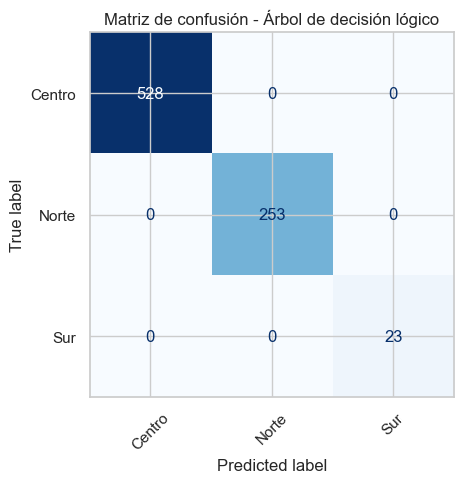

In [9]:
# =============================================================================
# 5.1 Árbol de decisión lógico (clasificación automática)
# =============================================================================

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Variables para clasificación
features_clf = ["Latitude", "Longitude", "Depth", "Magnitude"]
target_clf = "zona_sismica"

df_clf = df.dropna(subset=features_clf + [target_clf]).copy()

Xc = df_clf[features_clf]
yc = df_clf[target_clf]

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    Xc, yc, test_size=0.2, random_state=42, stratify=yc
)

arbol_clf = DecisionTreeClassifier(
    criterion="gini",
    max_depth=5,
    min_samples_leaf=30,
    random_state=42
)

arbol_clf.fit(Xc_train, yc_train)

yc_pred_test = arbol_clf.predict(Xc_test)

acc_arbol = accuracy_score(yc_test, yc_pred_test)
f1_arbol = f1_score(yc_test, yc_pred_test, average="macro")

print(f"Exactitud (accuracy) en test - Árbol lógico: {acc_arbol:.4f}")
print(f"F1-macro en test - Árbol lógico: {f1_arbol:.4f}")

cm_arbol = confusion_matrix(yc_test, yc_pred_test, labels=arbol_clf.classes_)
disp_arbol = ConfusionMatrixDisplay(confusion_matrix=cm_arbol, display_labels=arbol_clf.classes_)

fig, ax = plt.subplots(figsize=(5, 5))
disp_arbol.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Matriz de confusión - Árbol de decisión lógico")
plt.xticks(rotation=45)
plt.tight_layout()

guardar_figura(fig, "clasificacion_arbol_matriz_confusion")
plt.show()


Figura guardada en: figuras\clasificacion_arbol_logico.png


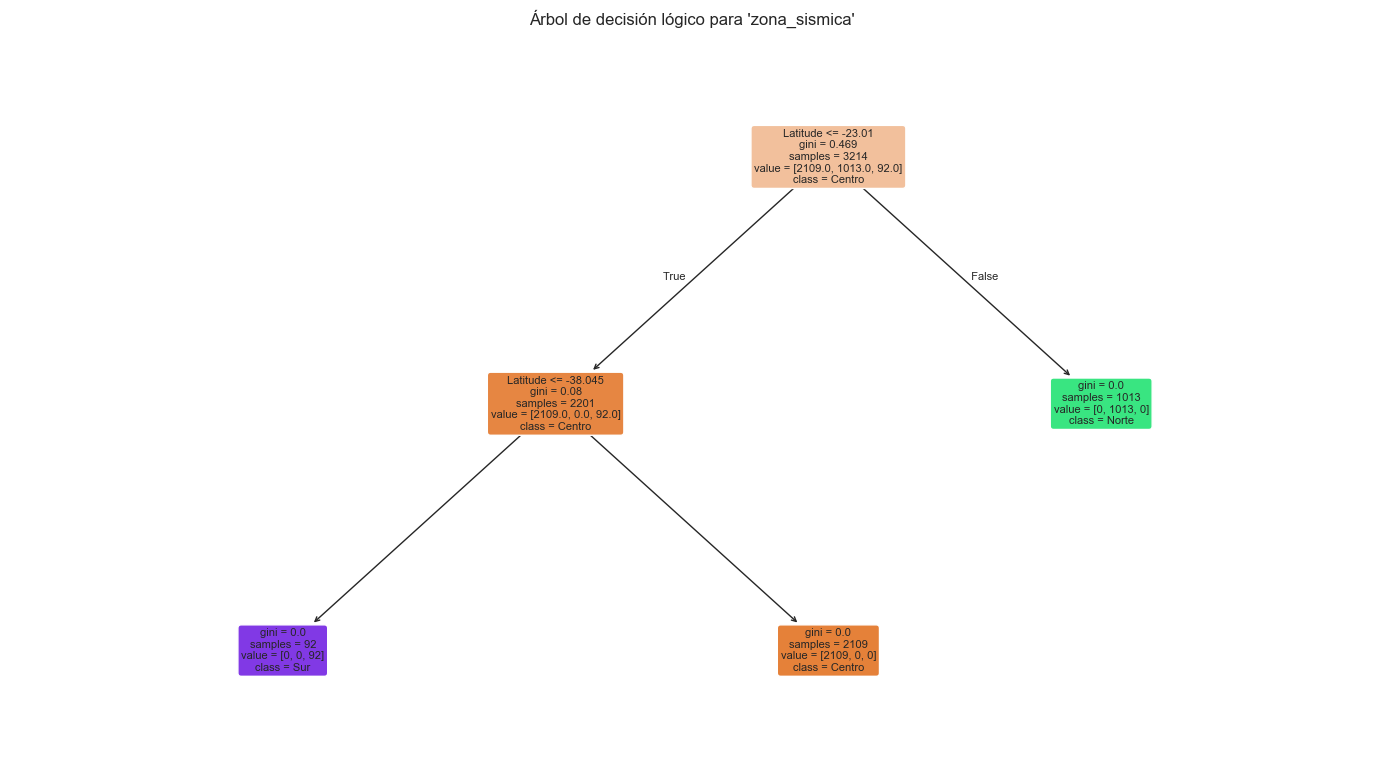

In [10]:
# =============================================================================
# 5.2 Visualización del árbol de decisión lógico
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 8))
plot_tree(
    arbol_clf,
    feature_names=features_clf,
    class_names=arbol_clf.classes_,
    filled=True,
    rounded=True,
    fontsize=8
)
ax.set_title("Árbol de decisión lógico para 'zona_sismica'")
plt.tight_layout()

guardar_figura(fig, "clasificacion_arbol_logico")
plt.show()


Exactitud (accuracy) en test - Random Forest: 1.0000
F1-macro en test - Random Forest: 1.0000
Figura guardada en: figuras\clasificacion_random_forest_matriz_confusion.png


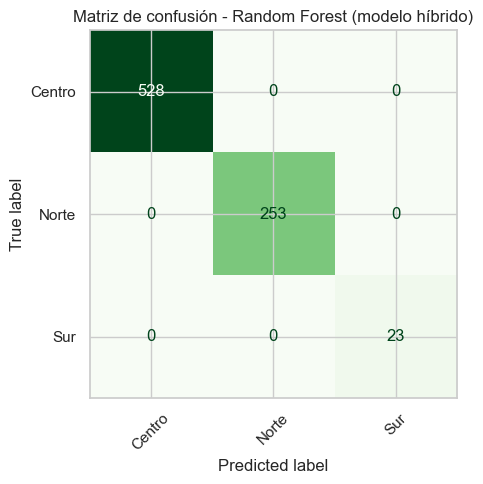

,Modelo,Accuracy_test,F1_macro_test
0,Árbol de decisión lógico,1.0000,1.0000
1,Random Forest (modelo híbrido),1.0000,1.0000


In [11]:
# =============================================================================
# 5.3 Modelo híbrido: Random Forest de clasificación
# =============================================================================

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

rf_clf.fit(Xc_train, yc_train)

yc_pred_rf = rf_clf.predict(Xc_test)

acc_rf = accuracy_score(yc_test, yc_pred_rf)
f1_rf = f1_score(yc_test, yc_pred_rf, average="macro")

print(f"Exactitud (accuracy) en test - Random Forest: {acc_rf:.4f}")
print(f"F1-macro en test - Random Forest: {f1_rf:.4f}")

cm_rf = confusion_matrix(yc_test, yc_pred_rf, labels=rf_clf.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_clf.classes_)

fig, ax = plt.subplots(figsize=(5, 5))
disp_rf.plot(ax=ax, cmap="Greens", colorbar=False)
ax.set_title("Matriz de confusión - Random Forest (modelo híbrido)")
plt.xticks(rotation=45)
plt.tight_layout()

guardar_figura(fig, "clasificacion_random_forest_matriz_confusion")
plt.show()

# Tabla comparativa de métricas de clasificación
df_resultados_clf = pd.DataFrame(
    [
        {"Modelo": "Árbol de decisión lógico", "Accuracy_test": acc_arbol, "F1_macro_test": f1_arbol},
        {"Modelo": "Random Forest (modelo híbrido)", "Accuracy_test": acc_rf, "F1_macro_test": f1_rf},
    ]
)
df_resultados_clf


### 5.4 Discusión de clasificación y árbol lógico manual

Los resultados de clasificación muestran que tanto el árbol de decisión lógico como el modelo híbrido de Random Forest son capaces de separar de forma perfecta las tres macrozonas sísmicas (Norte, Centro y Sur) usando las variables Latitude, Longitude, Depth y Magnitude. En el conjunto de prueba, ambos modelos alcanzan un 100 % de exactitud (accuracy) y un F1-macro igual a 1.0, y las matrices de confusión presentan solo valores en la diagonal.

A primera vista, una métrica perfecta podría parecer sospechosa en un problema de clasificación. Sin embargo, en este caso es un comportamiento esperable, porque la etiqueta `zona_sismica` fue construida de manera determinista a partir de la latitud. La regla utilizada en la preparación de datos fue:

- Si la **Latitude** es mayor o igual a aproximadamente \-23°, el evento se etiqueta como **Norte**.
- Si la Latitude es menor o igual a aproximadamente \-38°, el evento se etiqueta como **Sur**.
- Para latitudes intermedias entre esos dos umbrales, el evento se etiqueta como **Centro**.

El árbol de decisión lógico entrenado con scikit-learn redescubre exactamente esta regla, generando cortes muy similares en la latitud (\-23.01° y \-38.045°). Por esta razón, el modelo reproduce sin error la misma lógica que se usó para definir las clases, y obtiene una precisión del 100 % tanto en entrenamiento como en prueba. En otras palabras, no está “adivinando” más allá de los datos, sino replicando una relación que es totalmente determinista en el dataset.

A partir de estas reglas es posible construir un árbol lógico manual, similar a un árbol genealógico, que podría representarse en Draw.io o Visio de la siguiente forma:

- Nodo 1: ¿Latitude > \-23°?
  - Sí → Clasificar como **Norte**.
  - No → Ir a Nodo 2.
- Nodo 2: ¿Latitude ≤ \-38°?
  - Sí → Clasificar como **Sur**.
  - No → Clasificar como **Centro**.

Este esquema resume de manera sencilla la lógica de segmentación territorial del modelo y coincide con la intuición geográfica de las macrozonas sísmicas de Chile.

El modelo de Random Forest, en cambio, utiliza muchos árboles de decisión internos y resulta menos transparente, aunque en este caso no mejora las métricas respecto al árbol simple, precisamente porque la relación entre latitud y zona_sismica ya es completamente lineal por umbrales. Su principal aporte es la robustez para escenarios futuros donde la definición de las clases sea menos rígida o exista ruido en los datos. En este trabajo, dado que la etiqueta está definida de forma exacta a partir de la latitud, el árbol lógico simple es suficiente y tiene la ventaja de poder comunicarse fácilmente a usuarios no técnicos.



### 5.5 Árbol lógico manual de zona_sismica


La figura siguiente muestra el árbol lógico manual construido a partir de los umbrales de latitud definidos en el modelo automático.

![Árbol lógico manual zona_sismica](figuras/arbol_logico_zona_sismica.png)

El árbol se representa como una estructura genealógica, donde cada nodo corresponde a una pregunta sobre la latitud y cada hoja a una macrozona sísmica:

- Nodo raíz: ¿Latitude > −23°?
  - Si la respuesta es **Sí**, el evento se clasifica como **Norte**.
  - Si la respuesta es **No**, se pasa al nodo: ¿Latitude ≤ −38°?
    - Si la respuesta es **Sí**, se clasifica como **Sur**.
    - Si la respuesta es **No**, se clasifica como **Centro**.

Este árbol fue dibujado en Draw.io y exportado como imagen para incluirlo en el informe.
